## Objective

This a beginner's guide to SVM. Our goals are to understand

- When do we need to use Support Vector Machines?
- How to derive a Linear SVM model? What does Support Vectors mean?
- How to implement it in Python?
- How to deal with data which is not 'linearly seperabale' with Kernel Trick?
- What are the advantages of SVM over Decision Trees and Logistic Regression?
- What are it's limitations ?

## Data

To explore SVM model we will look at a [diagnostic dataset for breast cancer ](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

*You don't need to understand the data to learn basics of SVM. Think of the columns(features) as real numbers which have some correlation with the target class i.e. diagnosis*. However if you want to build a robust real world model, understanding your features is a key skill. 

 - ### Domain Background ([more info](http://dollar.biz.uiowa.edu/~street/research/hu_path95/hp95.pdf))
   This dataset was constructed by analzying images of breast masses of people 569 patients: 212 with cancer and 357 without cancer. Each data point corresponds to a patient and contains geometric properties of the tumor and the diagnosis. These  properties are modelled such that higher values are typically associated with malignant tumours.
   
   Diagnosis for the patients had been confirmed by additional surgical/lab procedures. **Our goal is to build a computer algorithm which can succesfully diagnose any patients in future, so as to (ideally)eliminate the need for expensive diagnostic proceedures.**
   
   *If you are curious, here are further details on how the data is obtained:* 
   
   *Images of fibrocystic breast masses are obtained using fine needle aspiration(FNA). Each patient has one FNA image. Each FNA image has several nuclei. Structural properties of each nuclei are calculated by a combination human observation and computer calculations. Nuclear size is given by radius and area. Shape is expressed by smoothness , concavity , compactness, concave points, symmetry and fractal dimension features. Both size and shape are expressed by perimeter. Nuclear texture is measured by finding the variance of gray scale intensities in pixels. The average, standard deviation and average of three worst values over all the nuclei for each feature is obtained. This gives 30 features for each patient.*


 - ### Description
   
   Here we will only look at the following columns of the data:
   
   - `patient_id` unique to a patient (integer valued) 
   - `diagnosis`  'M' for malignant and 'B' for benign
   - `radius_avg` average of radius of tumor (real valued)
   - `texture_avg` average of texture (real valued)
   - `permiter_avg` average of tumor perimeter (real valued)
   - `area_avg` average of tumor area
   - `smoothness_avg` average local variations in radius lengths
   - `compactness_avg` average(perimeter^2/area-1.0)
   - `concavity_avg` average severity of concave portions of the contour of tumor
   - `concave_points_avg` average number of concave portions of the contour
   - `symmetry_avg` average symmetry 
   - `fractal_dim_avg` average of fractal dimension ("coastline approximation" - 1)
   



In [35]:
import pandas as pd

# import data 
bc_data = pd.read_csv("wdbc.csv")
print(bc_data.head())

# converting diagnosis to integer value for easier math
bc_data['diagnosis'] = bc_data['diagnosis'].replace(['M', 'B'], [1,-1])

# some data cleaning to make it an ideal candidate for a Linear SVM model.
bc_data = bc_data[(bc_data['radius_avg'] < 12) | (bc_data['radius_avg'] > 15)]

# dividing into two datasets for plotting purposes
malignant = bc_data[bc_data['diagnosis']==1 ]
benign = bc_data[bc_data['diagnosis'] == -1]

         ID diagnosis  radius_avg  texture_avg  perimeter_avg  area_avg  \
0    842517         M       20.57        17.77         132.90    1326.0   
1  84300903         M       19.69        21.25         130.00    1203.0   
2  84348301         M       11.42        20.38          77.58     386.1   
3  84358402         M       20.29        14.34         135.10    1297.0   
4    843786         M       12.45        15.70          82.57     477.1   

   smoothness_avg  compactness_avg  concavity_avg  concave_points_avg  \
0         0.08474          0.07864         0.0869             0.07017   
1         0.10960          0.15990         0.1974             0.12790   
2         0.14250          0.28390         0.2414             0.10520   
3         0.10030          0.13280         0.1980             0.10430   
4         0.12780          0.17000         0.1578             0.08089   

   symmetry_avg  fractal_dim_avg  
0        0.1812          0.05667  
1        0.2069          0.05999  
2    

## When do we need SVM?

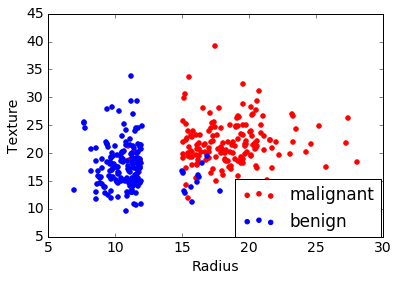

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=14)
plt.scatter(malignant['radius_avg'], malignant['texture_avg'],\
            color='r', label='malignant')
plt.scatter(benign['radius_avg'], benign['texture_avg'], 
            color='b', label='benign')
plt.xlabel('Radius')
plt.ylabel('Texture')
plt.legend(loc=(0.56,0))

As you can see from above figure, this data has a complex structure. It can be very hard to come up with a hypothesis which approximates the structure of such data (like we do in linear regression, where we assume data is linear with some noise added). Support Vector machines on the other hand pay little attention to the underlying structure. The aim here is to divided the domain of (radius, texture) into regions which contain only malignant or benign tumors. 

## How to derive a Linear SVM?

From above figure, notice that malignant and benign classes can be seperated easily by a line across the domain. Let's consider three lines $L_1, L_2 , L_3$. Which line would you pick?

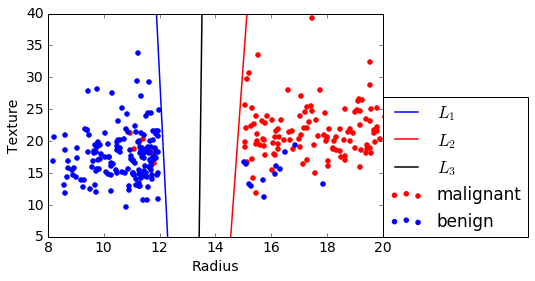

In [37]:
## Ignore this block of code.##

plt.scatter(malignant['radius_avg'], malignant['texture_avg'],\
            color='r', label='malignant')
plt.scatter(benign['radius_avg'], benign['texture_avg'], 
            color='b', label='benign')
# some rough manual math to get points to draw lines
rad1 = benign[benign['radius_avg'] < 12]['radius_avg'].idxmax()


# Points for Line 1 
p1 = benign[['radius_avg', 'texture_avg']].loc[rad1].tolist()
p2 = benign[['radius_avg', 'texture_avg']].loc[rad1].tolist()
p1[0] = p1[0] - 0.1
p1[1] = p1[1] + 15
p2[0] = p2[0] + 0.3
p2[1] = 5

plt.plot([p1[0], p2[0]], [p1[1],p2[1]],\
         linewidth=1.5, label=r'$L_1$')
plt.xlabel('Radius')
plt.ylabel('Texture')



# Points for Line 2
rad2 = malignant[malignant['radius_avg'] > 12]['radius_avg'].idxmin()
q1 = malignant[['radius_avg', 'texture_avg']].loc[rad2].tolist()
q2 = malignant[['radius_avg', 'texture_avg']].loc[rad2].tolist()
q1[0] = q1[0] + 0.1
q1[1] = q1[1] + 22
q2[0] = q2[0] - 0.5
q2[1] = 5
plt.plot([q1[0], q2[0]], [q1[1],q2[1]], color='r',\
         linewidth=1.5, label=r'$L_2$')

# Points for Line 3
s1 = [(p1[0]+q1[0])/2, p1[1]]
s2 = [(p2[0]+q2[0])/2, p2[1]]
plt.plot([s1[0], s2[0]], [s1[1],s2[1]],color='k',\
         linewidth=1.5, label=r"$L_3$")

plt.xlim([8,20])
plt.ylim([5,40])
plt.legend(loc=(1,0))


Suppose we pick Line $L_1$ to be our classifier line. Then all points to the right of $L_1$ will be classified as malignant and all point to the left will be benign. (*Note there are few points to the left and right of $L_1$ which will be misclassified, but these are very few and we will come back to them later.*). So $L_1$ does a great job of classifying the given dataset correctly. Same goes for $L_2$ and $L_3$.

But how well will these classifiers perform on unseen data? Afterall the goal here is to diagnose unclassified points. Suppose we choose to go with $L_1$. Now have to predict tumor with features $d_1$. (TODO:Insert figure here). $L_1$ will classify $d_1 = (12.5, 12.5)$ as malignant. But if we look at the figure, it's features are much closer to benign points. Similar argument can be made that $L_2$ will incorrectly classify $d_2 = (15,22.5)$  as benign. 

So even though both $L_1$ and $L_2$ have negligible error on training data, they generalize poorly to unseen data (i.e. have high error on testing data). 

What about $L_3$? It will correctly classify $d_1$ as benign and $d_2$ as malignant. Do you expect it's testing error to be higher or lower than $L_1$? 

What makes $L_3$ so special? Hint: Empty space on both sides.

### How do we find $L_3$

  We want $L_3$ to be as far away from data on both sides as possible.  All points below $L_3$ will be classified as benign(-1) and all points above will be classified as malignant(1). Since $L_3$ is the boundary, all points on it will be classified as unknown (let's label it as $0$)
  
  Let's denote radius by variable $x_r$ and texture by variable $x_t$. Then equation of $L_3$ can be written as $ x_t = mx_r + b$. Since both $x_r$ and $x_t$ are 'independent' variables in our problem (dependent variable is the diagnosis), let's make our equation more general by multiplying both sides by $w_t$ to get $ w_tx_t - w_tmx_r - w_tb = 0$. Substitute $w_r = -w_tm$ and $b' = w_tb$,  to get $w_tx_t + w_rx_r - b'=0$.
  
  Let's write this in vector form to generalize this equation to multiple features, take vector of weights $\mathbf{w} = \begin{bmatrix} w_t\\ w_r \end{bmatrix}$, vector of features 
  $\mathbf{x} = \begin{bmatrix} x_t\\ x_r\end{bmatrix}$. Then above equation can be written as 
  
  $$L_3: \mathbf{w}^T\mathbf{x} - b' = 0$$
  
 TODO: Insert a figure explaining projections.
  
### Equations for $L_1$ and $L_2$

  Since we don't have any other information in the middle region, so we just say $L_3$ divides the empty region in equal halves, i.e. both $L_1$ and $L_2$ are parallel and at equal distances from $L_3$.
  
  We can get $L_2$ by moving $L3$ in the direction of positive $\mathbf{w}$ by a distance $\delta$. Similarly move $L_3$ in direction of $-\mathbf{w}$ by $\delta$ to get $L_2$.
  
  So equations are
  
  $$
  L_2: \mathbf{w}^T\mathbf{x} - b' = \delta,\\
  L_1: \mathbf{w}^T\mathbf{x} - b' = -\delta
  $$
  
  Now we need to include information about the diagonsis in the equation order to make any predictions. From our earlier discussion , all points $\mathbf{x}$ lying on or below the line $L_1$ should be predicted as benign (which were denoting numerically as -1). So without loss of generality we can chose $\delta = 1$(this way we will have to worry about one less variable). Now if a point satisfies the relation $\mathbf{w}^T\mathbf{x} - b' \leq -1$, it will be classified as benign.
 
 Similarly all points which satisfy the relation $\mathbf{w}^T\mathbf{x} - b' \geq 1$, will be classified as malignant.

In conclusion, we have following equations:

  $$
  L_2: \mathbf{w}^T\mathbf{x} - b' = 1,\\
  L_1: \mathbf{w}^T\mathbf{x} - b' = -1
  $$

### How to find $\mathbf{w}$ and $b'$ ?
   
  Remember that we need to maximize the distance between $L_1$ and $L_2$, to minimize generalization error. First let's find the distance between $L_1$ and $L_2$ in terms of $\mathbf{w}$ and $b'$. 
  
  Consider two points $\mathbf{x_1}$ on $L_1$ and $\mathbf{x_2}$ on $L_2$. We have to find $\|\mathbf{x_1} - \mathbf{x_2}\|$ (here $\|...\|$ gives the magnitude of the vector). They will satisfy the following equations
  
   $$
  L_2: \mathbf{w}^T\mathbf{x_2} - b' = 1,\\
  L_1: \mathbf{w}^T\mathbf{x_1} - b' = -1
  $$
  
  Subtract second equation from first to get 
  
  $$ \mathbf{w}^T\mathbf{x_2} - \mathbf{w}^T\mathbf{x_1} = 2,\\
  \implies \mathbf{w}^T(\mathbf{x_2} - \mathbf{x_1}) = 2, \\
  \implies \|\mathbf{w}^T(\mathbf{x_2} - \mathbf{x_1})\| = 2,\\
  \implies \|\mathbf{w}\|\|\mathbf{x_2} - \mathbf{x_1}\| \leq \|\mathbf{w}^T(\mathbf{x_2} - \mathbf{x_1})\| = 2,\\
  \implies \|\mathbf{x_2} - \mathbf{x_1}\| \leq \dfrac{2}{\|\mathbf{w}\|}
  $$
  
  TODO: Add figure which shows the distance between x1 and x2 in direction of w is 2/||w||
  
  Our goal is to maximize $\|\mathbf{x_2} - \mathbf{x_1}\|$ which implies maximizing $\dfrac{2}{\|\mathbf{w}\|}$ , which implies minimizing $\|\mathbf{w}\|$. Also we want to classify everything correctly. 
  
  **TL;DR** So to summarize, our problem for finding linear seperator is to find $L_3$, which in turn can be found by finding $L_2$ and $L_1$, which are described by $\mathbf{w}$ and $b'$. All points on and below $L_1$ are classified as benign(-1).  All points on and above $L_3$ are classified as malignant(+1). $L_2$ and $L_1$ should be as far apart as possible.  So to find them, we have to maximize the distance between them $i.e. \dfrac{2}{\|\mathbf{w}\|}$, which is equivalent to minimizing $\frac{1}{2}\|\mathbf{w}\|^2$.
  
  
  $$ 
     \operatorname*{arg\,min}_{\mathbf{w}}\|\mathbf{w}\|,\\ 
     s.t.
     \;\mathbf{w}^T\mathbf{x_m} - b' \geq 1,\;\; \forall\; \mathbf{x_m},\\
     \;\;\;\;\mathbf{w}^T\mathbf{x_b} - b' \leq -1,\;\; \forall\; \mathbf{x_b},
     (TODO: Rewrite it in one equation)
  $$
  
  where $\mathbf{x_m}$ all points in the given dataset which are malignant and $\mathbf{x_b}$ all benign points. 
  
  This optimization problem is solved using quadratic programming. It is equivalent to the following problem. 
  
  
  Reformulate the problem in terms of support vectors !!

## How to implement in Python?

Python has inbuilt [`svm`](http://scikit-learn.org/stable/modules/svm.html) library which supports all kinds of SVM based classification and regression. Before doing any kind of machine learning it's is extremely important to split the data into training and testing set. We find the SVM seperator using training data. Then use testing data as example of unseen data to evalute how well the model will generalize. This prevents overfitting to the given data. 
Here we will use a simple split, to focus on SVM. But if you are new to data science, you should read about overfitting and cross-validation. 

In [32]:
# Splitting data into testing and training sets
from sklearn.cross_validation import train_test_split
features = bc_data.drop(['ID', 'diagnosis'], axis=1)
labels = bc_data['diagnosis']

# Using stratified sample ensures training and testing data will have 
## nearly equal percentage of both labels. This is specially important 
## when you have unbalanced data. Fix random_state to make results reproducible
features_train, features_test, labels_train, labels_test =\
                                    train_test_split(features,labels,\
                                                     test_size=0.2,\
                                                     stratify=labels,\
                                                     random_state=42)
# checking if training and testing have same % of labels
print(sum(labels_train==-1)/float(len(labels_train)))
print(sum(labels_test==-1)/float(len(labels_test)))

0.514705882353
0.507246376812


In [44]:
# Classification
from sklearn import svm

clf = svm.SVC(kernel='linear', random_state=42) # simple linear classifier
clf.fit(features_train[['texture_avg', 'radius_avg']], labels_train)

# Draw SVM boundary


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
labels_train.shape
labels_test.shape

(69,)